# Imports

In [382]:
import torch
import torchvision
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit

# Importing data

In [383]:
df = pd.read_csv("../Analyse/df_clean.csv", index_col=0)
df.head()

,time,name,activity,acc_x,acc_y,acc_z,mag_x,mag_y,mag_z,gyr_x,gyr_y,gyr_z,ori_x,ori_y,ori_z,ori_w,lat,long
0,2022-04-03 11:47:11.212,Raphi,Sitting,-0.091133,0.351148,0.945756,-23.0153,-26.7241,-33.4097,0.047035,-0.022907,0.008399,0.136017,-0.125171,-0.839552,0.510817,47.500155,8.324881
1,2022-04-03 11:47:11.268,Raphi,Sitting,-0.097963,0.366881,0.898528,-22.9726,-26.5960,-33.2694,-0.050089,-0.041232,-0.025808,0.135422,-0.126965,-0.839437,0.510728,47.500155,8.324881
2,2022-04-03 11:47:11.326,Raphi,Sitting,-0.114793,0.334654,0.998473,-22.7774,-26.5106,-33.0925,0.150879,-0.098041,0.096972,0.134209,-0.126197,-0.839677,0.510821,47.500155,8.324881
3,2022-04-03 11:47:11.388,Raphi,Sitting,-0.075767,0.364564,0.886332,-22.9421,-26.7790,-32.9461,0.196082,0.096208,-0.009926,0.134518,-0.133009,-0.839076,0.510125,47.500155,8.324881
4,2022-04-03 11:47:11.445,Raphi,Sitting,-0.125556,0.378345,0.905358,-23.3264,-27.3524,-32.9705,0.027488,0.019242,0.138510,0.139961,-0.133803,-0.836808,0.512193,47.500155,8.324881


/Users/ronnyschneeberger/Documents/FHNW/FS22/cdl1/activity_tracker/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


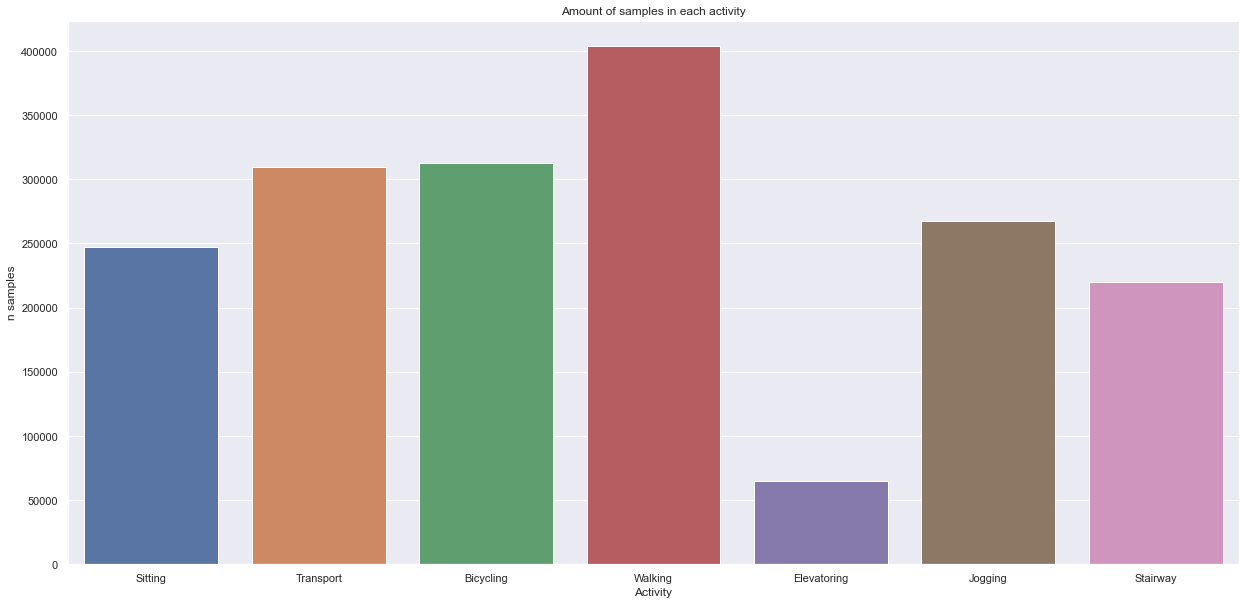

In [384]:
# set sns plot size to (21, 10)
sns.set(rc={'figure.figsize': (21, 10)})
# plot amount of samples in df.activity
sns.countplot(df.activity)
plt.xlabel("Activity")
plt.ylabel("n samples")
plt.title("Amount of samples in each activity")
plt.show()

Elevatoring is undersampled. The recognition of elevatoring is not mandatory in the challenge. Therefore not many samples were collected. 

## Encoding activity

In [385]:
df.activity.unique()

array(['Sitting', 'Transport', 'Bicycling', 'Walking', 'Elevatoring',
       'Jogging', 'Stairway'], dtype=object)

In [386]:
# encode activities to numbers
df.activity = df.activity.map({'Sitting': 0, 'Transport': 1, 'Bicycling':2, 'Walking':3, 'Elevatoring':4, 'Jogging':5, 'Stairway':6})

In [387]:
df.activity.unique()

array([0, 1, 2, 3, 4, 5, 6])

# Turning raw data into samples

To train a model that recognizes activity, the input data is a timeseries which contains datapoints over a period of time. With a single recorded datapoint the model won't be able to recognize the activity. 

Therefore the data was split into recording samples. With recording samples are all the datapoints meant which were created during a recording session. 

The recording are further split into model samples which can be served to a model. The model samples are smaples over a timespan of 2.56 seconds and can have around 50% overlap. This seems to be a standart procedure in activity recognition. (https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/) (https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition)

## Creating test dataset for testing splitting

In [388]:
test = df.iloc[:1000,:]

## Check for amount of different activities

In [389]:
# check how many recording samples are in test
print(test.activity.unique())
print(test.name.unique())

[0 1 2]
['Raphi' 'pascal']


## Create columns for distinguishing samples

In [390]:
# copy time to new column and move it one row down
test['time_copy'] = test.time

# move time_copy next to the front
columns = list(test.columns)
columns = columns[-1:] + columns[:-1]
test = test[columns]

# shift time copy
test.time_copy = test.time_copy.shift(-1)

# calc diff
test['time_diff'] = (pd.to_datetime(test.time_copy) - pd.to_datetime(test.time))
test['time_diff'] = test['time_diff'].abs()

# apply total seconds
test.time_diff = test.time_diff.apply(lambda x: x.total_seconds())

# set sampleid to 0
test['sampleid'] = 0

# copy activity to new column and move it one row down
test['activity_copy'] = test.activity
test.activity_copy = test.activity_copy.shift(-1)

# check if activity is the same
test['activity_diff'] = test.activity == test.activity_copy

sampleid = 0

/var/folders/w3/qczdk1p16437g5rs9gnqc6_c0000gn/T/ipykernel_56694/1611528737.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['time_copy'] = test.time


## Check where splitting should occur

In [368]:
test[test.activity_diff != True]

,time_copy,time,name,activity,acc_x,acc_y,acc_z,mag_x,mag_y,mag_z,...,ori_x,ori_y,ori_z,ori_w,lat,long,time_diff,sampleid,activity_copy,activity_diff
200,2022-04-03 07:45:01.017,2022-04-03 11:47:22.835,Raphi,0,-0.121379,0.333922,0.940268,-21.4354,-26.75460,-32.07380,...,0.141825,-0.114015,-0.850270,0.493864,47.500155,8.324881,14541.818,0,1.0,False
803,2022-03-03 17:15:40.471,2022-04-03 07:49:28.105,pascal,1,-0.089975,0.397401,0.926030,-1.5375,-16.53750,6.43125,...,0.184056,0.099057,0.249243,0.945597,47.469938,8.317365,2644427.634,0,2.0,False
999,NaN,2022-03-03 17:15:51.148,pascal,2,0.670832,-0.326787,-0.508627,-23.9250,29.76563,40.23750,...,-0.081741,-0.893293,-0.197210,0.395543,47.455777,8.324452,NaN,0,NaN,False


## set sampleid

In [391]:
# create sampleids
prev_index = -1
id = 0

# create indexes where activity is not the same and time diff is greater than 1
indexes = test[(test.activity_diff == False) & (test.time_diff > 1)].index.tolist()

for index in indexes:
    print(prev_index, index)
    test.loc[prev_index+1:index, 'sampleid'] = id
    prev_index = index
    id += 1
test.loc[prev_index:, 'sampleid'] = id

-1 200
200 803


## Split a single sample into model samples

In [392]:
test_model = test[test.sampleid == 0].drop(columns=['time_copy', 'activity_copy', 'activity_diff'])
print(test_model.iloc[:43,:].sum().time_diff, test_model.iloc[:43,:].count().activity)
print(test_model.iloc[44:44+43,:].sum().time_diff, test_model.iloc[43:44+42,:].count().activity)

2.502 43
2.538 43


In [393]:
splits = np.array_split(test_model.iloc[:int(np.floor(test_model.shape[0] / 43)) * 43, :], 4)
[split.time_diff.sum() for split in splits]

[2.502, 2.5360000000000005, 2.4650000000000003, 2.4489999999999994]

43 samples seem to amount to a timerange around 2.56 seconds. 

In [394]:
def create_modelsampleids(df:pd.DataFrame, samplesize:int) -> (pd.DataFrame, np.array):
    X = np.array([])
    y = np.array([])
    df['modelsampleid'] = 0
    columns = list(df.columns)
    columns.remove('activity')
    count = 0
    df_ids = pd.DataFrame(columns=columns)

    for id in list(df.sampleid.unique()):
        # filter by id
        temp = df[df.sampleid == id]
        # drop activity
        temp_y = temp.activity.iloc[0]
        print(temp_y)
        temp = temp.drop(columns=['activity'])
        n = int(np.floor(temp.shape[0] / samplesize))
        temp = temp.iloc[:n*samplesize,:]
        splits = np.array_split(temp, n)

        for split in splits:
            split['modelsampleid'] = count
            count += 1

        temp = np.vstack(splits)
        # np array to df_ids
        temp = pd.DataFrame(temp, columns=columns)

        df_ids = pd.concat([df_ids, temp])

    df_ids = df_ids.reset_index()
    df_ids = df_ids.drop(columns=['index', 'time_copy', 'time_diff', 'activity_copy', 'activity_diff', 'sampleid'])
    assert df_ids.shape[0] / samplesize == df_ids['modelsampleid'].nunique()

    data = np.array([X, y])

    return df_ids, data

In [395]:
df, data = create_modelsampleids(test, 43)

0
1
1


In [396]:
df.columns

Index(['time', 'name', 'acc_x', 'acc_y', 'acc_z', 'mag_x', 'mag_y', 'mag_z',
       'gyr_x', 'gyr_y', 'gyr_z', 'ori_x', 'ori_y', 'ori_z', 'ori_w', 'lat',
       'long', 'modelsampleid'],
      dtype='object')

## Splitting data
The data is split with StratifiedShuffleSplit to keep the proportions of the different classes intact.

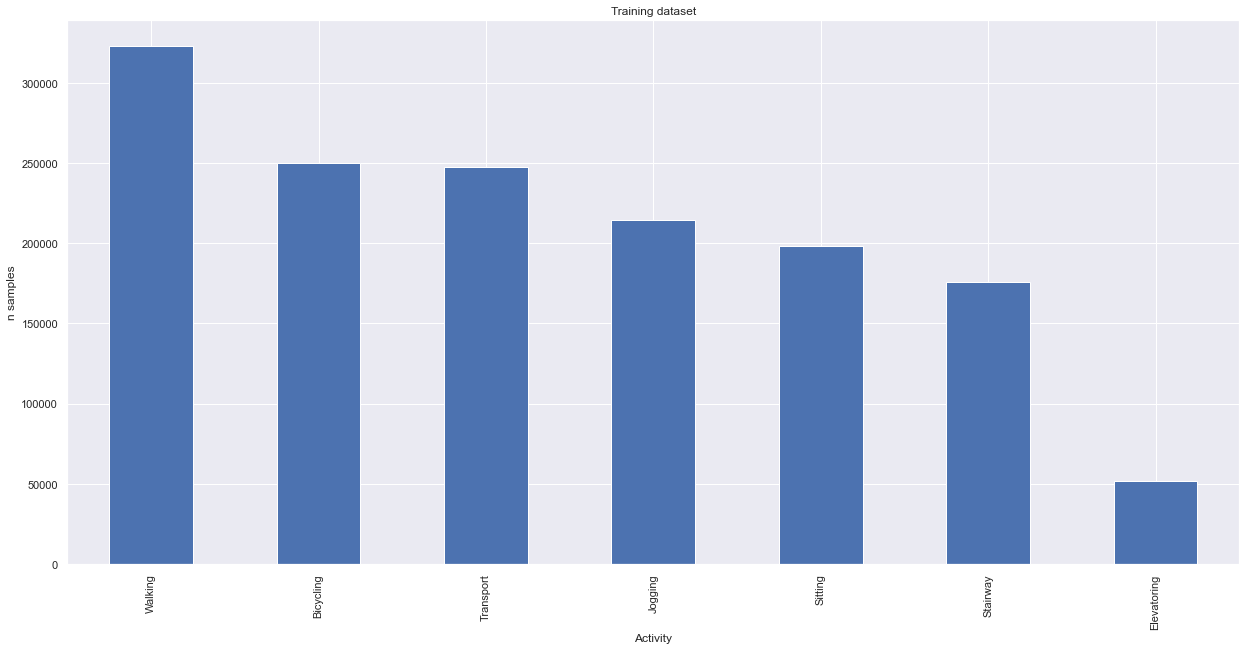

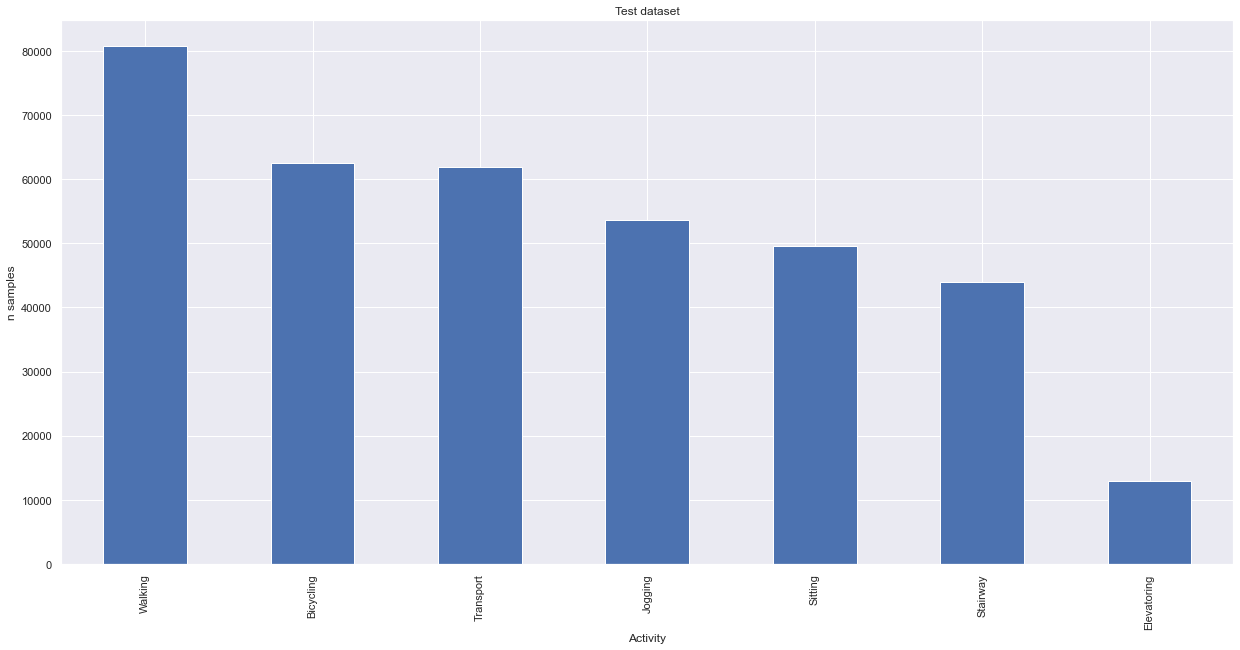

In [21]:
# split df into train and test StratifiedShuffleSplit by activity
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

train_index, test_index = next(split.split(df, df.activity))
train_df = df.iloc[train_index]
test_df = df.iloc[test_index]

# show amount of samples in train and test in two plots matplotlib
train_df.activity.value_counts().plot.bar()
plt.xlabel("Activity")
plt.ylabel("n samples")
plt.title("Training dataset")
plt.show()
test_df.activity.value_counts().plot.bar()
plt.title("Test dataset")
plt.xlabel("Activity")
plt.ylabel("n samples")
plt.show()